In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) # this goes *before* tf import

In [2]:
from IPython.display import Image, display
import numpy as np
import os
from os.path import join
from PIL import ImageFile
import pandas as pd
from matplotlib import cm
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.isotonic import IsotonicRegression
import re

import cv2 as cv
import pickle

ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
train_img_dir_n = r"dataset\pn_dataset/cassava"
train_img_paths_n = [join(train_img_dir_n,filename) for filename in os.listdir(train_img_dir_n)]

In [4]:
train_img_paths, test_img_paths_cassava = train_test_split(train_img_paths_n, test_size=0.25, random_state=42)
train_img_paths, val_img_paths_cassava = train_test_split(train_img_paths, test_size=0.25, random_state=42)

In [5]:
natural_images_path = r"dataset\pn_dataset/"
test_img_paths_no_cassava = []
for d in [d for d in os.listdir(r"dataset\pn_dataset") if d!= "cassava"]:
    test_img_dir_na = natural_images_path+d
    test_img_paths_no_cassava.append([join(test_img_dir_na,filename) for filename in os.listdir(test_img_dir_na)])
    
test_img_paths_no_cassava_flat = [item for sublist in test_img_paths_no_cassava for item in sublist]
test_img_paths_no_cassava, val_img_paths_no_cassava = train_test_split(test_img_paths_no_cassava_flat, test_size = 0.25, random_state = 42)

In [6]:
def natural_img_dir(image_path):
    path_regex = r"pn_dataset\/(\w*)"
    if 'pn_dataset' in image_path:
        return re.findall(path_regex,image_path,re.MULTILINE)[0].strip()
    else:
        return 'cassava'

In [7]:
all_test_paths = test_img_paths_cassava+test_img_paths_no_cassava
test_path_df = pd.DataFrame({
    'path': all_test_paths,
    'is_cassava': [1 if path in test_img_paths_cassava else 0 for path in all_test_paths]
})
test_path_df = shuffle(test_path_df,random_state = 0).reset_index(drop = True)
test_path_df['image_type'] = test_path_df['path'].apply(lambda x: natural_img_dir(x))
all_test_paths = test_path_df['path'].tolist()

In [8]:
print('Distribution of Image Types in Test Set')
print(test_path_df['image_type'].value_counts())

Distribution of Image Types in Test Set
cassava      5350
fruit         769
person        723
car           718
cat           671
flower        633
motorbike     600
dog           535
airplane      525
Name: image_type, dtype: int64


In [9]:
all_val_paths = val_img_paths_cassava+val_img_paths_no_cassava
val_path_df = pd.DataFrame({
    'path': all_val_paths,
    'is_cassava': [1 if path in val_img_paths_cassava else 0 for path in all_val_paths]
})
val_path_df = shuffle(val_path_df,random_state = 0).reset_index(drop = True)
val_path_df['image_type'] = val_path_df['path'].apply(lambda x: natural_img_dir(x))
all_val_paths = val_path_df['path'].tolist()

In [10]:
print('Distribution of Image Types in Validation Set')
print(val_path_df['image_type'].value_counts())

Distribution of Image Types in Validation Set
cassava      4012
person        263
car           250
fruit         231
cat           214
flower        210
airplane      202
motorbike     188
dog           167
Name: image_type, dtype: int64


# Feature Extraction With ResNet50

In [15]:
# prepare images for resnet50
image_size = 84
def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    #output = img_array
    output = preprocess_input(img_array)
    return(output)

In [16]:
X_train = read_and_prep_images(train_img_paths)
X_test = read_and_prep_images(all_test_paths)
X_val = read_and_prep_images(all_val_paths)

In [17]:
# get features from resnet50 

# resnet_weights_path = 'C:\Github\Cassava-Disease-Classification-Using-Line-BOT\resNet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# X : images numpy array



In [18]:
# get features from resnet50 

# resnet_weights_path = 'C:\Github\Cassava-Disease-Classification-Using-Line-BOT\resNet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# X : images numpy array

from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(input_shape=(image_size, image_size, 3),weights="imagenet",include_top=False, pooling='avg')  # Since top layer is the fc layer used for predictions

X_train = resnet_model.predict(X_train)
X_test = resnet_model.predict(X_test)
X_val = resnet_model.predict(X_val)

180/180 [==============================] - 2s 13ms/step


# Scaling and PCA

In [19]:
# # Apply standard scaler to output from resnet50
# ss = StandardScaler()
# ss.fit(X_train)
# X_train = ss.transform(X_train)
# X_test = ss.transform(X_test)
# X_val = ss.transform(X_val)

# # Take PCA to reduce feature space dimensionality
# pca = PCA(n_components=512, whiten=True)
# pca = pca.fit(X_train)
# print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)
# X_val = pca.transform(X_val)

# One Class SVM vs Isolation Forest

In [20]:
# Train classifier and obtain predictions for OC-SVM
oc_svm_clf = svm.OneClassSVM(gamma=0.001, kernel='rbf', nu=0.08)  # Obtained using grid search
if_clf = IsolationForest(contamination=0.08, max_features=1.0, max_samples=1.0, n_estimators=40)  # Obtained using grid search

from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose=1, mode="auto",patience=3)

oc_svm_clf.fit(X_train)
if_clf.fit(X_train)

oc_svm_preds = oc_svm_clf.predict(X_test)
if_preds = if_clf.predict(X_test)

In [21]:
svm_if_results=pd.DataFrame({
  'path': all_test_paths,
  'oc_svm_preds': [0 if x == -1 else 1 for x in oc_svm_preds],
  'if_preds': [0 if x == -1 else 1 for x in if_preds]
})


svm_if_results=svm_if_results.merge(test_path_df)
svm_if_results.head()

,path,oc_svm_preds,if_preds,is_cassava,image_type
0,dataset\pn_dataset/fruit\fruit_0652.jpg,0,0,0,fruit
1,dataset\pn_dataset/cassava\3985539982.jpg,1,1,1,cassava
2,dataset\pn_dataset/cassava\2457479781.jpg,1,1,1,cassava
3,dataset\pn_dataset/fruit\fruit_0708.jpg,0,0,0,fruit
4,dataset\pn_dataset/cassava\645991519.jpg,1,1,1,cassava


roc auc score: if_preds
0.9377652099462084
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5174
           1       0.95      0.93      0.94      5350

    accuracy                           0.94     10524
   macro avg       0.94      0.94      0.94     10524
weighted avg       0.94      0.94      0.94     10524



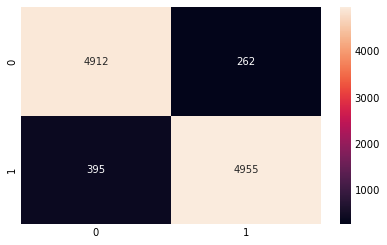

In [22]:
print('roc auc score: if_preds')
if_preds=svm_if_results['if_preds']
actual=svm_if_results['is_cassava']
print(roc_auc_score(actual, if_preds))
print(classification_report(actual, if_preds))
sns.heatmap(confusion_matrix(actual, if_preds),annot=True,fmt='2.0f')
plt.show()

roc auc score: oc_svm_preds
0.9482586187587831
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      5174
           1       0.99      0.91      0.95      5350

    accuracy                           0.95     10524
   macro avg       0.95      0.95      0.95     10524
weighted avg       0.95      0.95      0.95     10524



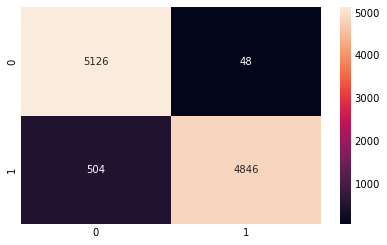

In [23]:
print('roc auc score: oc_svm_preds')
oc_svm_preds=svm_if_results['oc_svm_preds']
actual=svm_if_results['is_cassava']
print(roc_auc_score(actual, oc_svm_preds))
print(classification_report(actual, oc_svm_preds))
sns.heatmap(confusion_matrix(actual, oc_svm_preds),annot=True,fmt='2.0f')
plt.show()

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


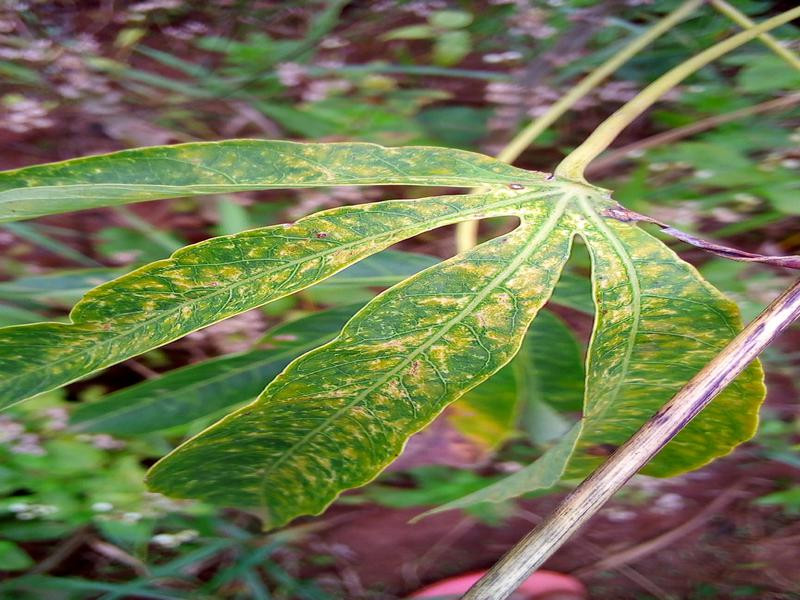

FALSE NEGATIVE
oc_svm_preds: 0 | actual: 1


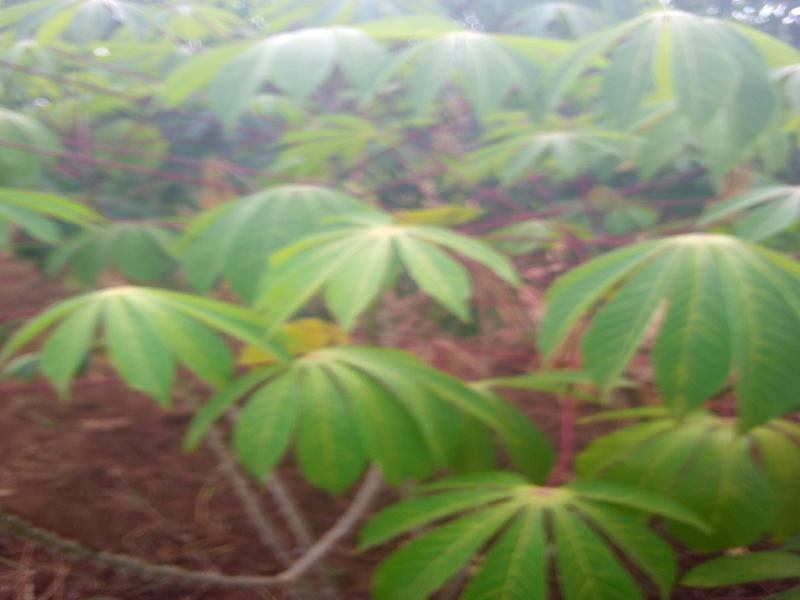

In [24]:
for index, row in svm_if_results[svm_if_results['oc_svm_preds']!=svm_if_results['is_cassava']].head(2).iterrows():
    if row['oc_svm_preds']==1:
        print('FALSE POSITIVE')
        print('oc_svm_preds: ' + str(row['oc_svm_preds']) + ' | actual: '+ str(row['is_cassava']))
        display(Image(row['path']))
    else:
        print('FALSE NEGATIVE')
        print('oc_svm_preds: ' + str(row['oc_svm_preds']) + ' | actual: '+ str(row['is_cassava']))
        display(Image(row['path']))

In [25]:
# Save Model 
pickle.dump(oc_svm_clf, open("model/OCC_SVM_VER_01.sav", 'wb'))

# Prediction

In [26]:
import pickle
import cv2 as cv
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

In [27]:
# predict one by one , Khae Long Mai Ru Thuk Mai

def pred_(img_path):
    image_size = 128

    # Initialize model 
    occ_model = pickle.load(open("model/OCC_SVM_VER_01.sav", 'rb'))
    resnet_model = ResNet50(input_shape=(image_size, image_size, 3), weights="imagenet", include_top=False, pooling='avg') 

    # Load Image
    test_imgs = cv.imread(img_path)
    type(test_imgs)
    test_imgs = cv.cvtColor(test_imgs, cv.COLOR_BGR2RGB)
    test_imgs = cv.resize(test_imgs, (image_size, image_size)).reshape(-1, image_size, image_size, 3)
    output = preprocess_input(test_imgs)

    # Feature Extraction Using RESNET-50
    img_predict = resnet_model.predict(output)

    # Predict 
    oc_svm_preds = occ_model.predict(img_predict)

    # output
    if(oc_svm_preds[0]==-1):
        pred = 0
    else:
        pred = 1
    print(f"RESULT : {pred}")


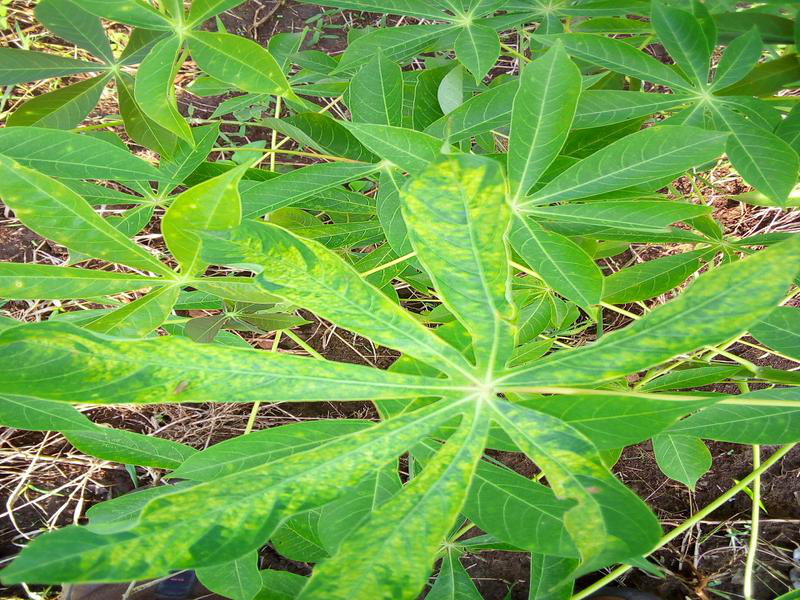

1/1 [==============================] - 1s 766ms/step
RESULT : 1


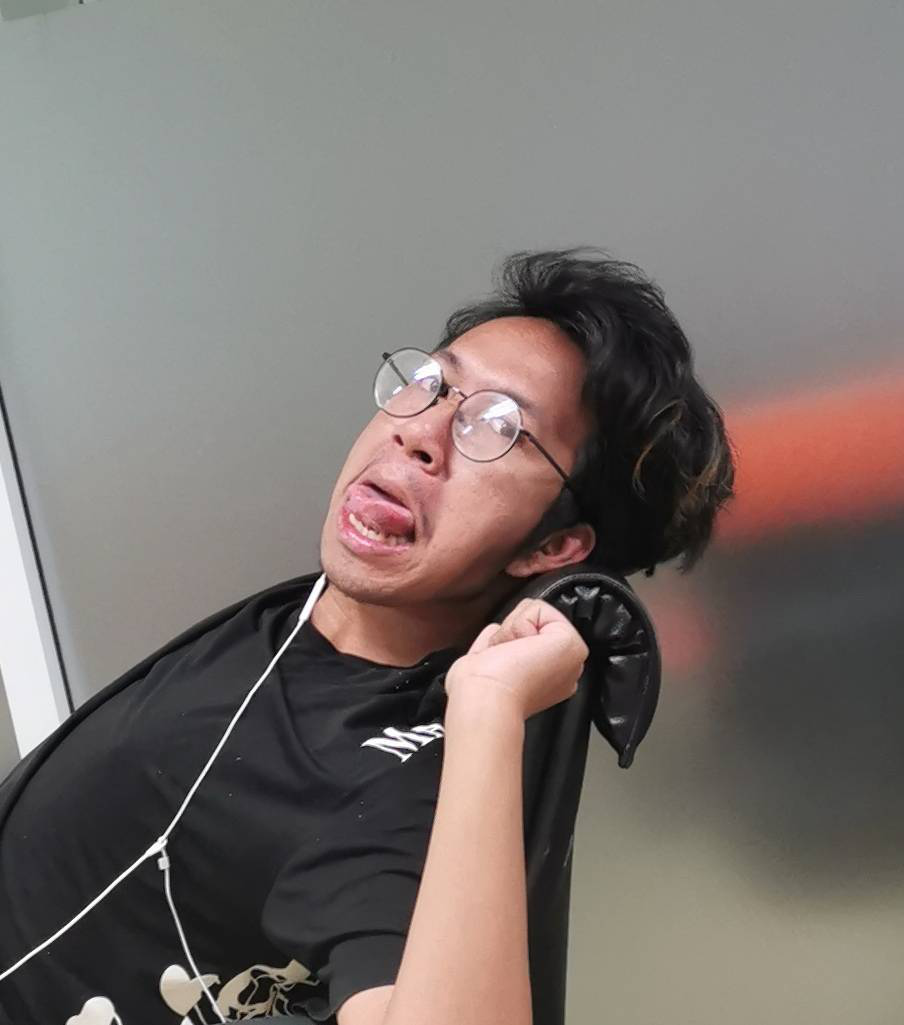

1/1 [==============================] - 1s 568ms/step
RESULT : 0


In [28]:
display(load_img(r"test\01.jpg"))
pred_(r"test\01.jpg")
display(load_img(r"test\02.jpg"))
pred_(r"test\02.jpg")